We've learned about the multi-head attention mechanism. We will now learn to code the other building blocks of an LLM and assemble them into a GPT-like model.

We start with a simplified version of a GPT-like model as an example. It consists of token and positional embeddings, dropout, a series of transformer blocks, a final layer of normalisation, and a linear output layer. The configuration is passed in via a python dictionary.

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # num of words used by BPE tokenizer
    "context_length": 1024, # max num of input tokens model can handle
    "emb_dim": 768,         # embedding size: each token -> 768-d vector
    "n_heads": 12,          # num of heads in multi-head attention mechanism
    "n_layers": 12,         # num of transformer blocks in the model
    "drop_rate": 0.1,       # 10% random dropout of hidden units 
    "qkv_bias": False       # whether to include a bias vector in linear layers
}    

In [2]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) # placeholder for transformer block
              for _ in range(cfg["n_layers"])]
        )

        self.final_norm = DummyLayerNorm(cfg["emb_dim"]) # placeholder for layernorm
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [3]:
class DummyTransformerBlock(nn.Module): # a placeholder to be replaced later
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x # block does nothing but return its input
    

class DummyLayerNorm(nn.Module): # a placeholder to be replaced later
    def __init__(self, normalised_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

The forward method describes the data flow through the model: it computes token and positional embeddings for the input indices, applies dropout, processes the data through the transformer blocks, applies normalisation, and finally produces logits with the linear output layer.

Now, we prepare the input data and initialise a new GPT model to illustrate its usage.

In [4]:
import tiktoken

tokeniser = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokeniser.encode(txt1)))
batch.append(torch.tensor(tokeniser.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


Now we initialise a new 124-mllion parameter DummyGPTModel instance and feed it the tokenised batch.

In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


The output tensor has two rows, corresponding to the two text samples. Each text consists of 4 tokens; each token is a 50,257-dimensional vector, which matches the size of the tokeniser's vocab. Each of these dimensions refers to a unique token in the vocab. Later, we will convert these vectors back into token IDs, which we can then decode into words. 

### Normalising activations with layer normalisation

Training deep neural networks with many layers can prove challenging due to problems like vanishing or exploding gradients. These lead to unstable training dynamics and make it difficult for the network to effectively adjust its weights - so the learning process struggles to find a set of parameters (weights) for the network that minimises the loss function. In other words, the network has difficulty learning the underlying patterns in the data, affecting its ability to make accurate predictions.

<i>Layer normalisation</i> is designed to improve the stability and efficiency of neural network training. The idea is to adjust the activations (outputs) of a neural network layer to have a mean of 0 and a variance of 1 (a.k.a. unit variance). This speeds up the convergence to effective weights and ensures consistent, reliable training. In GPT-2, this is typically applied before and after the multi-head attention module and before the final output layer. 

In [6]:
torch.manual_seed(123)
batch_example = torch.rand(2, 5) # 2 training examples with 5 dimensions each (features)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)


In [7]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)


As can be seen, the means are above 0 and variances are far from 1. 

Using keepdim=True ensures that the ouput tensor retains the same number of dimensions as the input tensor, even though the operation (in this case mean and variance) reduces the tensor along the dimension specified via 'dim'. Without it, the returned mean tensor would be a two-dimensional vector insted of a 2x1-dimensional matrix. The dim parameter specifies the dimension along which the calculation should be performed. 

Dim=-1 (and dim=1 in this case as it's a 2-d tensor, so same thing) calculates the mean across the column dimension to obtain one mean per row (dim=0 would do so across the row dimension to obtain one mean per column). Later, when adding layer normalisation to the GPT model, which produces three-dimensional tensors with shape [batch_size, num_tokens, embedding_size], we still use dim=-1 for normalisation across the last dimension. 

Next, we apply layer normalisation.

In [8]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalised layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalised layer outputs:
 tensor([[-0.8603, -0.8603,  0.5869,  1.4698,  0.5242, -0.8603],
        [-0.7450, -0.7450, -0.0102,  0.4844,  1.7608, -0.7450]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[0.0000e+00],
        [9.9341e-09]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


The second value in the mean tensor above is 9e-09 - a value very close to zero. Small numerical errors can accumulate because of the finite precision with which computers represent numbers. We can improve readability by switching off scientific notation.

In [9]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [11]:
# Update the layer norm class
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

This implementation of layer normalisation operates on the last dimension of the input tensor x, which represents the embedding dimension. The variable 'eps' is a small constant added to the variance to prevent division by zero during normalisation. The 'scale' and 'shift' are two trainable parameters (of the same dimension as the input) that the LLM automatically adjusts during training. 

Note in the GPT class, we set 'unbiased = False'. In the variance calculation, we divide by the number of inputs n in the variance formula. Bessel's correction uses n-1 in the denominator to adjust for bias in the sample variance estimation. So dividing by n results in a biased estimate of the variance. For LLM's, the embedding dimension n is significantly large and so the difference between using n and n-1 is negligible. We are choosing this approach because it was used to implement the original GPT-2 model.

In [12]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

# For some reason, unbiased = False moved variance from 0.99 -> 0.80. Not in the book.

Mean:
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.7999],
        [0.7999]], grad_fn=<VarBackward0>)


Another popular type of normalisation is batch normalisation, which normalises across the batch dimension, whereas layer normalisation normalises across the feature (embedding) dimension. LLMs require significant computational resources, and the specific hardware or use case can dictate the batch size during training or inference. Since layer normalisation normalises each input independently of the batch size, it offers more flexibility and stability in these scenarios. It is particularly beneficial for distributed training or when deploying models in environments where resources are constrained. 

### Implementing a feed forward network with GELU activations

Historically, the ReLU activation function has been used in deep learning due to its simplicity and effectiveness across various neural network architectures. In LLMs, the activation functions of choice tend to be the GELU (Gaussian error linear unit) and SwiGLU (Swish-gated linear unit). They are more complex and smooth activation functions incorporating Gaussian and sigmoid-gated linear units respectively, and offer improved performance. 

The GELU has an exact version, but the GPT-2 version implemented a computationally cheaper approximation. PyTorch can implement this approximate version but perhaps not at the time Raschka was writing this book, so what follows is the manual implementation.

In [13]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

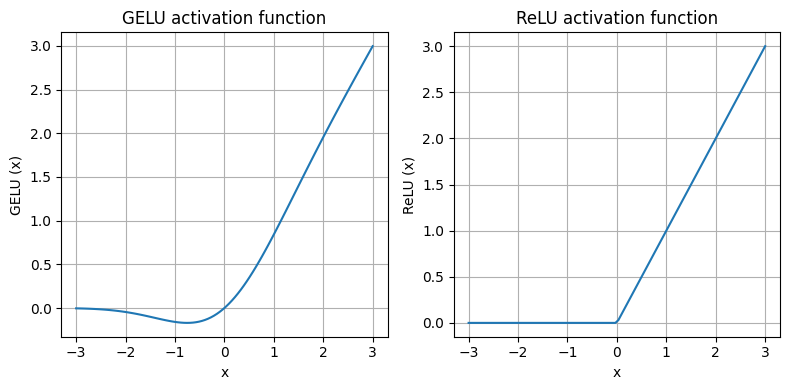

In [14]:
# Comparison of GELU and ReLU side by side
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100) # 100 sample data points between -3 and 3
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8,4))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label} (x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

The smoothness of GELU can lead to better optimisation properties during training, as it allows for more nuanced adjustments to the model's parameters. In contrast, ReLU has a sharp corner at 0, which can sometimes make optimisation harder, especially in networks that are very deep or have complex architectures. ReLU ouputs 0 for any negative input, whereas GELU allows for a small, non-zero output for negative values, which means that during the training process, neurons that receive negative input can still contribute to the learning process, albeit to a lesser extent than positive inputs. 

Next, we will use GELU to implement a MLP class (Raschka calls it FeedForward). The FeedForward module plays a crucial role in the model's ability to learn from and generalise the data. Although the input and output dimensions of this module are the same, it internally expands the embedding dimension into a higher dimensional space through the first linear layer (shown in code 2 cells below), followed by the GELU activation function, and then a contraction back into the original dimension via the second linear layer. This design allows for the exploration of a richer representation space. The uniformity in input and output dimension simplifies the architecture by enabling the stacking of multiple layers, without the need to adjust dimensions between them, thus making the model more scalable. 

In [15]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)

The FeedForward module is a small neural network consisting of two linear layers and a GELU activation function. In the 124 million parameter GPT model, it receives the input batches with tokens that have an embedding size of 768 each, via the GPT_CONFIG_124M dictionary. 

So for example with a batch size of 32, 50_000 tokens, and an embedding size of 768, the journey looks like:
1. Input tensor with shape (32, 50_000, 768).
2. The first linear layer increases the embedding dimension by 4x -> (32, 50_000, 3072).
3. This passes through the GELU activation function.
4. The second linear layer decreases the embedding dimension by 4x -> (32, 50_000, 768) is the output tensor. 

In [16]:
# An example with our small batch example
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


### Adding shortcut connections

Also known as skip or residual connections. They are there to mitigate the challenge of vanishing gradients (where gradients, which guide weight updates during training) become progressively smaller as they propagate backward through the layers, making it difficult to effectively train earlier layers. A shortcut connection creates an alternative, shorter path for the gradient to flow through the network, skipping one or more layers, which is achieved by adding the output of one layer to the output of a later layer. 

In [17]:
# A neural network to illustrate shortcut connections
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
                          GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x) # compute output of current layer
            if self.use_shortcut and x.shape == layer_output.shape: # check if shortcut applied
                x = x + layer_output
            else:
                x = layer_output
        return x

A deep neural network with 5 layers, each consisting of a linear layer and a GELU activation function. In the forward pass, we iteratively pass the input through the layers and optionally add the shortcut connections if self.use_shortcut = True.

Examples below. PyTorch computes the loss gradient for each layer in the model, so we can iterate through the weight parameters via model.named_parameters(). If we have a 3x3 weight parameter matrix for a given layer, the layer will have 3x3 gradient values. The function below prints the mean absolute gradient of these values to obtain a single gradient value per layer - to compare the gradients between layers more easily. 

In [18]:
# A function to compute the gradients in the model's backward pass
def print_gradients(model, x):
    output = model(x) # forward pass
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target) # calculate loss

    loss.backward() # backward pass to calculate gradients

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [19]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


We can see above that the gradients become smaller as we progress from the last layer to the first layer, which is the <i>vanishing gradient problem</i>. As can be seen below, using shortcut connections means the gradient doesn't shrink to a vanishingly small value. 

In [21]:
# Model with skip connections
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)

print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


### Connecting attention and linear layers in a transformer block

The transformer block is a fundamental building block of GPT and other LLM architectures. It is repeated a dozen times in the GPT-2 architecture and combines several concepts already covered: multi-head attention, layer normalisation, dropout, feed forward layers, and GELU activations. 

When a transformer block processes an input sequence, each element in the sequence (e.g. a word or sub-word token) is represented by a fixed-sized vector (in this case 768 dimensions). The operations within the transformer block are designed to transform these vectors in a way that preserves their dimensionality. The idea is that the self-attention mechanism in the multi-head attention block identifies and analyses relationships between elements in the input sequence. The feedforward network modifies the data individually at each position. This combination not only enables a more nuanced understanding and processing of the input but also enhances the model's overall capacity for handling complex data patterns.

In [23]:
# Transformer block in code
from Chapter04 import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        
        shortcut = x 
        x = self.norm1(x)
        x = self.att(x) # shortcut connection for attention block
        x = self.drop_shortcut(x)
        x = x + shortcut # adds the original input back

        shortcut = x 
        x = self.norm2(x)
        x = self.ff(x) # shortcut connection for mlp block
        x = self.drop_shortcut(x)
        x = x + shortcut # adds the original input back
        return x

This transformer block contains a multi-head attention block and a feed forward network, configured based on the configuration library. Layer normalisation is applied before each of these two components and dropout is applied after them to regularise the model and prevent overfitting (<i>Pre-LayerNorm</i>). The class also implements the forward pass, where each component is followed by a shortcut connection that adds the input of the block to its output. 

In [24]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) # batch_size, num_tokens, emb_dim
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


The transformer block maintains the dimensions from input to output. This is a crucial aspect of its design, which enables its effective application across a wide range of sequence-to-sequence tasks, where each output vector directly corresponds to an input vector, maintaining a one-to-one relationship. However, the output is a context vector that encapsulates information from the entire input sequence. This means that while the physical dimensions of the sequence (length and feature size) remain unchanged as it passes through the transformer block, the content of each output vector is re-encoded to integrate contextual information across the entire input sequence. 

### Coding the GPT Model

We replace the DummyTransformerBlock and DummyLayerNorm placeholders with the updated versions. Thanks to the TransformerBlock class, the GPTModel class is relatively small and compact - but in GPT-2 the transformer block is repeated 12 times (n_layers in the dictionary) and 48 times in the largest GPT-2 model with 1,542 million parameters. The output from the final transformer block then goes through a final layer normalisation step before reaching the linear output layer. This layer maps the transformer's output to a high-dimensional space (in this case 50,257 dimensions corresponding to vocab size) to predict the next token in the sequence.

In [25]:
import torch
import torch.nn as nn

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) 
              for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"]) 
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

The init constructor initialises the token and positional embedding layers using the configurations passed in via the GPT dictionary. These embedding layers are responsible for converting input tokens indices into dense vectors and adding positional information. The init method also creates a sequential stack of transformer blocks, a layernorm layer is applied, standardising the outputs from the transformer blocks to stabilise the learning process. Finally, a linear output head without bias is defined, which project's the transformer's output into the vocab space of the tokeniser to generate logits for each token in the vocab.

The forward method takes a batch of input token indices, computes their embeddings, applies the positional embeddings, passes the sequence through the transformer blocks, normalises the final output, and then computes the logits, representing the next token's unnormalised probabilities (these still need to be converted into tokens).

In [26]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0079, -0.1957,  ..., -0.0222, -0.1062,  0.1717],
         [ 0.3867, -0.8400, -0.6558,  ..., -0.5162,  0.2362, -0.3349],
         [ 0.6985, -0.1826, -0.1634,  ...,  0.1472, -0.6503, -0.0054],
         [-0.4288,  0.1670, -0.1262,  ...,  1.1571,  0.5297, -0.5542]],

        [[ 0.1095, -0.2890, -0.1463,  ..., -0.0557,  0.2907, -0.2818],
         [ 0.0884, -0.3545, -0.3524,  ...,  1.2921,  0.0050,  0.1902],
         [ 0.6092,  0.4702, -0.4093,  ...,  0.7682,  0.3781, -0.1968],
         [-0.0608, -0.0739,  0.4747,  ...,  1.2458, -0.3834,  0.0612]]],
       grad_fn=<UnsafeViewBackward0>)


The output tensor has shape [2, 4, 50_257] since we passed in two input texts with four tokens each. The last dimension corresponds to the vocab size of the tokeniser. 

Using the numel() method (number of elements), we can collect the total number of parameters in the model's parameter tensors. 

In [27]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


Why are there 163 million parameters instead of 124 million? Because of a concept called <i>weight tying</i>, used in the original GPT-2 architecture. It means that that model reuses the weights from the token embedding layer in its output layer. Look at the shapes of both layers.

In [28]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [29]:
# The above have the same shape
# Let's remove the output layer parameter count from the model's parameter count
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)

print(f"Number of trainable parameters considering weight typing: {total_params_gpt2:,}")

Number of trainable parameters considering weight typing: 124,412,160


Now we have 124 million parameters. Weight tying reduces overall memory footprint and computational complexity of the model. However, using separate token embedding and output layers results in better training and model performance; hence in our implementation we use separate layers. 

Lastly, let's compute memory requirements. Assuming each parameter is a 32-bit float taking up 4 bytes, the total size of the model is 621.83MB.

In [30]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB
